# Week 4: NLP Disaster Tweets Kaggle Mini-Project

## 1. Introduction
This mini-project aims to develop a machine learning model that is capable of classifying tweets as either related to real disasters or not. The dataset used in this project is retrieved from Kaggle competition "Natural Language Processing with Disaster Tweets": https://www.kaggle.com/competitions/nlp-getting-started/data. I will explore the data, preprocess it, build and train a Recurrent Neural Network (RNN) model, and evaluate its performance. The ultimate goal is to submit predictions for the test set and assess the model's effectiveness in identifying disaster-related tweets.

## 2. Exploratory Data Analysis (EDA)
In this section, I begin by importing the necessary libraries, including those for data manipulation, visualization, and model building. I then load the `train.csv` and `test.csv` datasets and inspect their structure.

I check for missing values in the dataset and compute basic statistics to understand the distribution of the data. Finally, I plot the distribution of the target variable in the training set to gain a preliminary understanding of the data. This initial exploration helps me get familiar with the dataset and informs my preprocessing steps.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(train_df.head())
print(test_df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [3]:
# Check for missing values
print(train_df.isnull().sum())

# Basic statistics about the data
print(train_df.describe())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


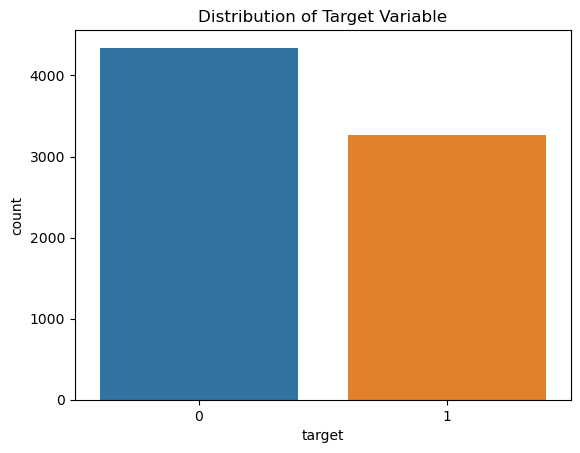

In [4]:
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

## 3. Model Building & Training
To start with, I defined a function to clean the tweet text by removing URLs, HTML tags, and punctuation, and converting the text to lowercase. This ensures that the text data is standardized and ready for model building. Then, I split the training data into two parts: one for training the model and the other for validating its accuracy. This allows me to monitor the model's performance on unseen data during training.

In [5]:
import re
import string

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    return text

# Apply preprocessing to the text column
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Display the first few rows of the preprocessed text
print(train_df['text'].head())

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object


In [6]:
max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['text'])

X_train = tokenizer.texts_to_sequences(train_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = train_df['target'].values

In [7]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)


Training data shape: (6090, 100)
Validation data shape: (1523, 100)


In [8]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

C:\Users\Cecile\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


I compile the model using binary cross-entropy as the loss function and Adam as the optimizer. The model is trained for 5 epochs on the training data, with validation data being used to monitor performance after each epoch. The training process is key to adjusting the model's parameters to minimize the loss and improve accuracy.

In [9]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.5645 - loss: 0.6844 - val_accuracy: 0.5739 - val_loss: 0.6669
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6479 - loss: 0.6176 - val_accuracy: 0.8004 - val_loss: 0.4735
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8539 - loss: 0.3729 - val_accuracy: 0.7892 - val_loss: 0.4834
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9111 - loss: 0.2690 - val_accuracy: 0.7925 - val_loss: 0.4978
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9438 - loss: 0.1867 - val_accuracy: 0.7761 - val_loss: 0.5580


## 4. Model Evaluation

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Validation Accuracy: 0.7760998030203545
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       874
           1       0.75      0.71      0.73       649

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



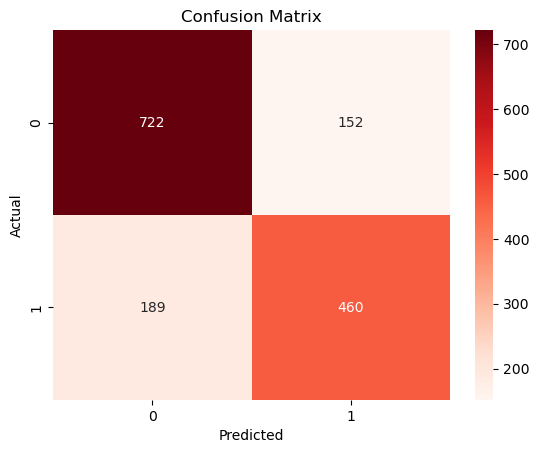

In [10]:
# Predict on the validation set
y_val_pred = (model.predict(X_val) > 0.5).astype("int32")

# Accuracy score
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 5. Generate Predictions for Test Folder

In [11]:
# Predict on the test set
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")

# Generate submission csv file
submission_df = pd.DataFrame({'id': test_df['id'], 'target': y_test_pred.flatten()})
submission_df.to_csv('submission.csv', index=False)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


## 6. Conclusion
This project demonstrated the process of developing a machine learning model to classify disaster-related tweets using Recurrent Neural Networks (RNNs). After performing data preprocessing steps such as text cleaning, tokenization, and padding, I built and trained an RNN model. The model was then evaluated on a validation set, achieving reasonable accuracy in classifying tweets. Finally, predictions were generated for the test set, and a submission file was prepared for the Kaggle competition. The techniques and data processing methods used in this project are versatile and can be applied not only to the classification of disaster-related tweets but also to a wide range of other text classification tasks.